In [2]:
%load_ext autoreload
%autoreload 2

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

from crypto_prediction.data.fetch_data import fetch_data

In [4]:
df = fetch_data('BTC-USD')[1:]
df = pd.DataFrame(df.close)
df.head()

[*********************100%***********************]  1 of 1 completed


,close
timestamp,
2023-02-06,22760.109375
2023-02-05,22955.666016
2023-02-04,23331.847656
2023-02-03,23449.322266
2023-02-02,23471.871094


In [5]:
mm_scaler = MinMaxScaler()
df_scaled = mm_scaler.fit_transform(df)
df_scaled

array([[0.30348714],
       [0.30652703],
       [0.31237471],
       ...,
       [0.09230751],
       [0.0869576 ],
       [0.09223958]])

In [13]:
period = 20
def split_dataset(df, period):
    X = list()
    y = list()
    
    for i in range(len(df) - period - 1):
        X.append(df[i:(i + period), 0])
        y.append(df[i + period, 0])
        
    X = np.array(X)
    y = np.array(y)
    
    return X, y
        
X_train, y_train = split_dataset(df_scaled, period)

In [7]:
X_train.shape

(1811, 20)

In [8]:
y_train.shape

(1811,)

## Modeling

In [9]:
model = Sequential()

model.add(layers.LSTM(100, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(layers.Dropout(0.3))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dropout(0.3))

model.add(layers.Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')


2023-02-07 21:36:30.323626: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
history = model.fit(
    X_train, y_train,
    #callbacks=[es],
    #validation_split=0.2,
    epochs=20,
    batch_size=12,
    verbose=1
)

Epoch 1/20
151/151 [==============================] - 6s 12ms/step - loss: 0.0059
Epoch 2/20
151/151 [==============================] - 2s 12ms/step - loss: 0.0030
Epoch 3/20
151/151 [==============================] - 2s 13ms/step - loss: 0.0028
Epoch 4/20
151/151 [==============================] - 2s 13ms/step - loss: 0.0021
Epoch 5/20
151/151 [==============================] - 2s 13ms/step - loss: 0.0019
Epoch 6/20
151/151 [==============================] - 2s 12ms/step - loss: 0.0018
Epoch 7/20
151/151 [==============================] - 2s 15ms/step - loss: 0.0016
Epoch 8/20
151/151 [==============================] - 3s 21ms/step - loss: 0.0016
Epoch 9/20
151/151 [==============================] - 3s 18ms/step - loss: 0.0014
Epoch 10/20
151/151 [==============================] - 3s 17ms/step - loss: 0.0016
Epoch 11/20
151/151 [==============================] - 2s 16ms/step - loss: 0.0016
Epoch 12/20
151/151 [==============================] - 2s 13ms/step - loss: 0.0015
Epoch 13/20
1

In [15]:
X_test = df.iloc[:,0:].values
X_test.shape

(1832, 1)

In [16]:
y_real = df.iloc[period+1:,0:].values
y_real.shape

(1811, 1)

In [17]:
X_test = mm_scaler.transform(X_test)
X_test, y_test = split_dataset(X_test, period)

/Users/oksanamishchenko/.pyenv/versions/3.8.12/envs/crypto_prediction/lib/python3.8/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [18]:
X_test.shape

(1811, 20)

In [20]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test.shape

(1811, 20, 1)

In [24]:
y_pred = model.predict(X_test)
prediction = mm_scaler.inverse_transform(y_pred)
prediction.shape

57/57 [==============================] - 0s 8ms/step


(1811, 1)

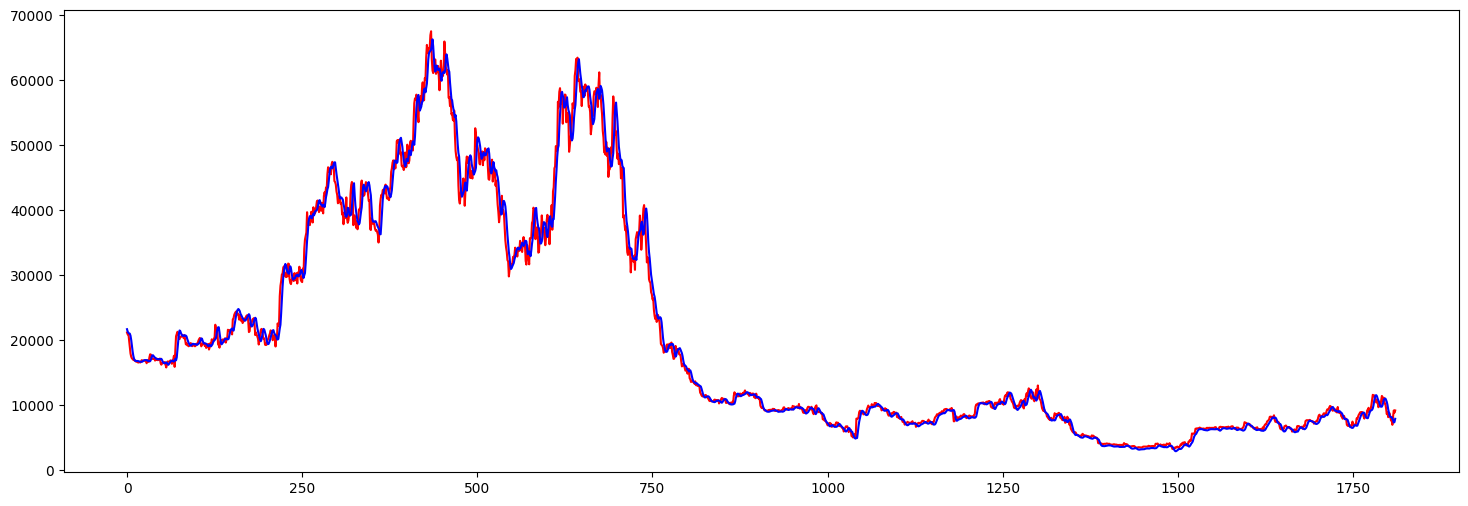

In [29]:
plt.figure(figsize=(18,6))
plt.plot(y_real, color='red', label='Real')
plt.plot(prediction, color='blue', label='Prediction')